In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
import os 

import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, cross_val_predict,
                                     cross_val_score, train_test_split)

import numpy as np 

from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

print(rdkit.__version__)

208
[('MaxEStateIndex', <function MaxEStateIndex at 0x7f850b00b880>), ('MinEStateIndex', <function MinEStateIndex at 0x7f850b00b910>), ('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7f850b00b9a0>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7f850b00ba30>), ('qed', <function qed at 0x7f850b04a9e0>)]
2022.03.5


In [2]:
molecules = []
fnames = []
lnames = []
labels = []

for dir in os.listdir('./data'):
    if os.path.isdir('./data/'+dir):
        for file in os.listdir('./data/'+dir):
            if file.endswith('.pdb'):
                m = rdkit.Chem.rdmolfiles.MolFromPDBFile('./data/'+dir+"/"+file)
                if m is None:
                    print("Error reading file:", file)
                else:
                    molecules.append(m)
                    fnames.append(dir.rstrip().lstrip())

fp = open('./data/labels.txt', 'r')

for line in fp:
    sline = line.rstrip().lstrip().split()
    lnames.append(sline[1])
    labels.append(float(sline[-1]))

fp.close()

fingersize = 64
rdgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=fingersize)

np_bits_l = []
np_counts_l = []
moldescriptors = []

for m in molecules:
    np_bits = rdgen.GetFingerprintAsNumPy(m)
    np_bits_l.append(np_bits)
    np_counts = rdgen.GetCountFingerprintAsNumPy(m)
    np_counts_l.append(np_counts)

    res = {}
    missingVal=None
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(m)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal

        res[nm] = val

    moldescriptors.append(res)

for i in range(len(moldescriptors)):
    for k,v in moldescriptors[i].items():
        if v is None:
            moldescriptors[i][k] = 0.0
        elif v is np.nan:   
            moldescriptors[i][k] = 0.0 

Error reading file: struc.pdb


[14:13:29] WARNING: not removing hydrogen atom without neighbors
[14:13:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[14:13:29] WARNING: not removing hydrogen atom without neighbors
[14:13:29] WARNING: not removing hydrogen atom without neighbors
[14:13:29] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol/Descriptors/BCUT.cpp
Failed Expression: 0
****

[14:13:29] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol/Descriptors/BCUT.cpp
Failed Expression: 0
****

[14:13:29] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol

In [3]:
np_bits_features = []
np_counts_features = []
moldescriptors_featues = []
Y = []
names = []

s_fnames = set(fnames)
s_lnames = set(lnames)
s_int = s_fnames.intersection(s_lnames)
for molname in s_int:
    #get index of molname in fnames
    idx = fnames.index(molname)
    np_bits_features.append(np_bits_l[idx])
    np_counts_features.append(np_counts_l[idx])
    val = [i for i in moldescriptors[idx].values()]
    moldescriptors_featues.append(val)
    #get index of molname in lnames
    idx2 = lnames.index(molname)
    Y.append(labels[idx2])
    names.append(molname)

Y = np.array(Y)
np_bits_features = np.array(np_bits_features)
np_counts_features = np.array(np_counts_features)
moldescriptors_featues = np.array(moldescriptors_featues)

moldescriptors_featues = np.nan_to_num(moldescriptors_featues, 0.0)

2023-10-25 14:13:29.304165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 14:13:29.344810: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


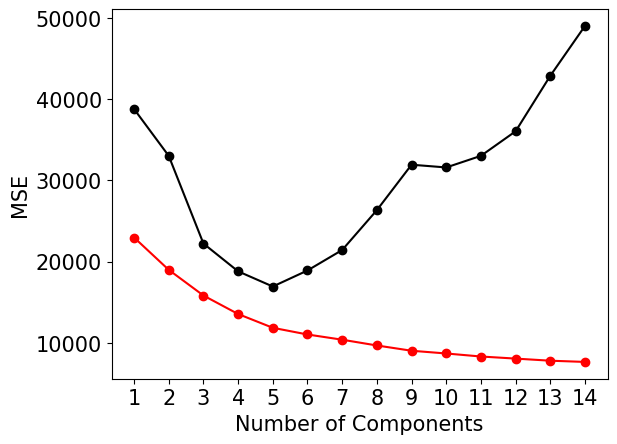

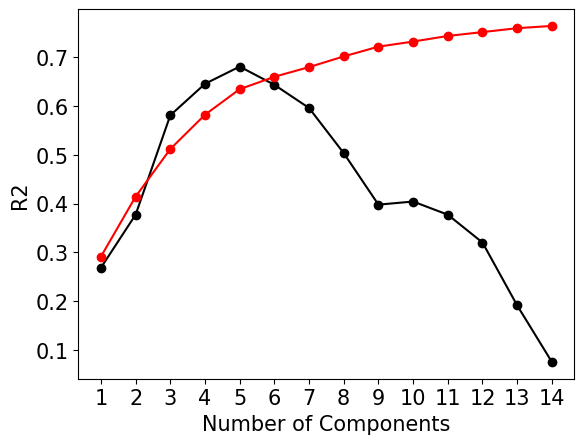

In [4]:
import models 
%reload_ext models

perc_split = 0.2
models.pls_model (0.2, np_counts_features, Y)

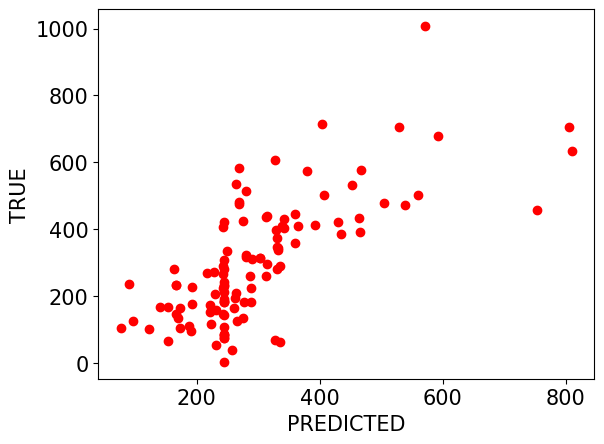

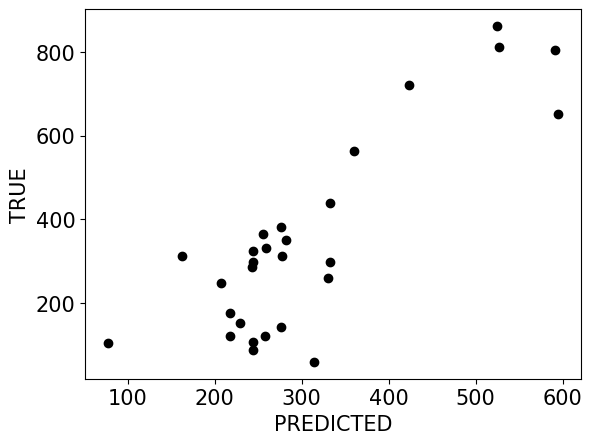

In [5]:
perc_split = 0.2
models.pls_model (0.2, np_counts_features, Y, False, 3)

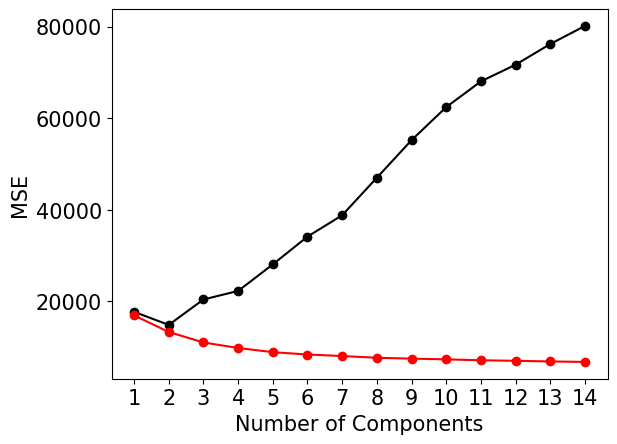

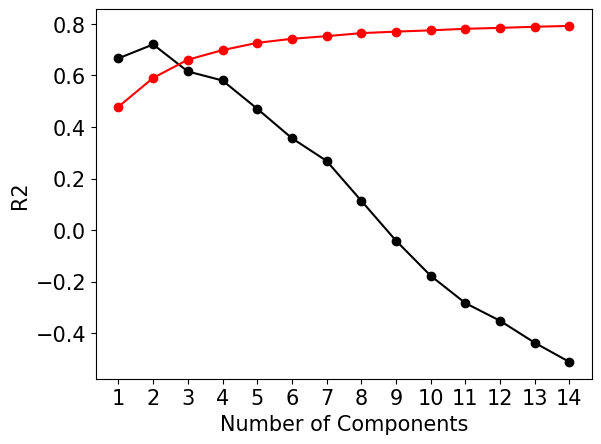

In [6]:
perc_split = 0.2
models.pls_model (0.2, np_bits_features, Y)

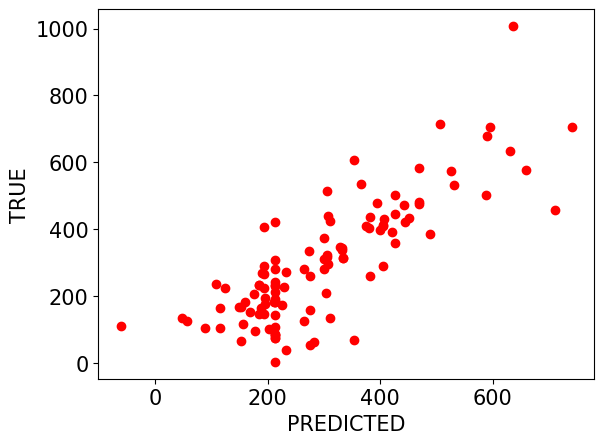

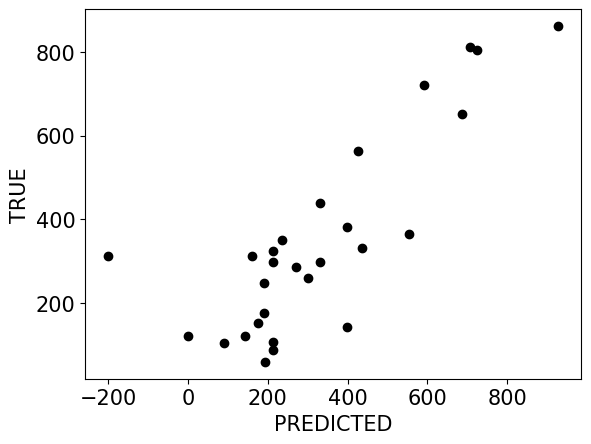

In [7]:
perc_split = 0.2
models.pls_model (0.2, np_bits_features, Y, False, 3)

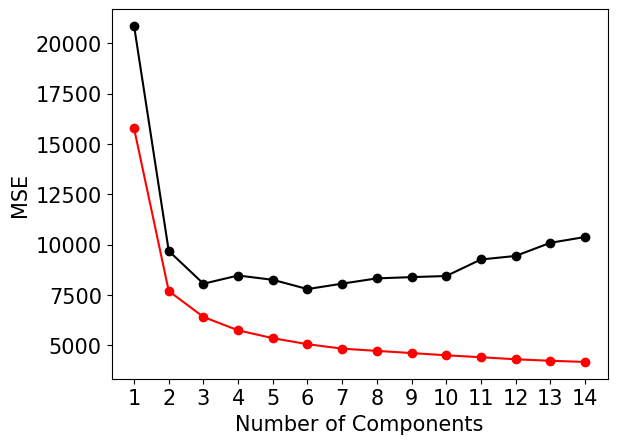

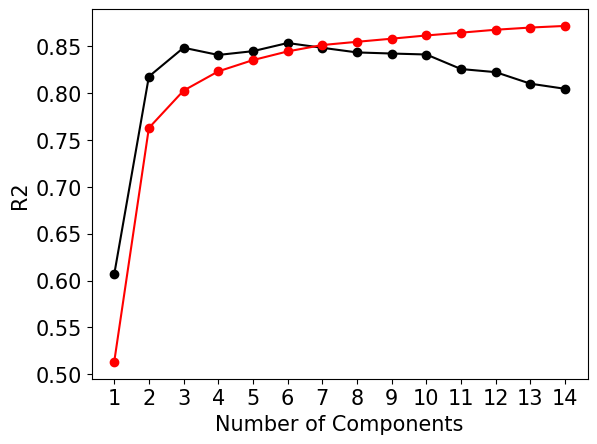

In [8]:
perc_split = 0.2
models.pls_model (0.2, moldescriptors_featues, Y)

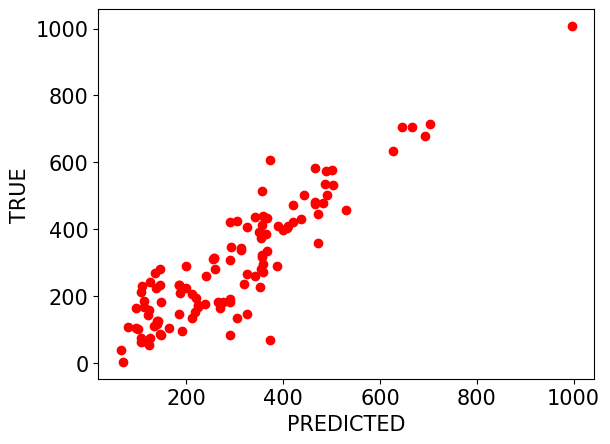

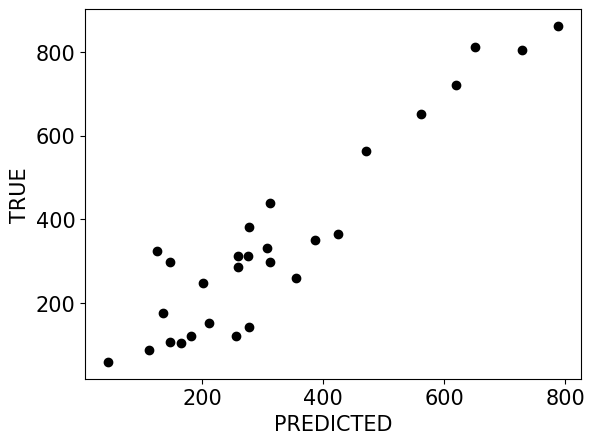

In [9]:
perc_split = 0.2
models.pls_model (0.2, moldescriptors_featues, Y, False, 3)

min_train_mse_hyper:  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 42, 'bootstrap': True, 'max_features': 100}
min_test_mse_hyper:  {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 42, 'bootstrap': True, 'max_features': 100}
max_train_r2_hyper:  {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 42, 'bootstrap': True, 'max_features': 100}
max_test_r2_hyper:  {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 10, 'random_state': 42, 'bootstrap': True, 'max_features': 100}


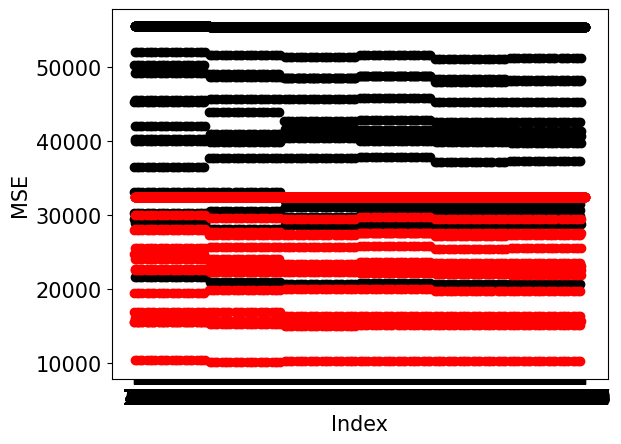

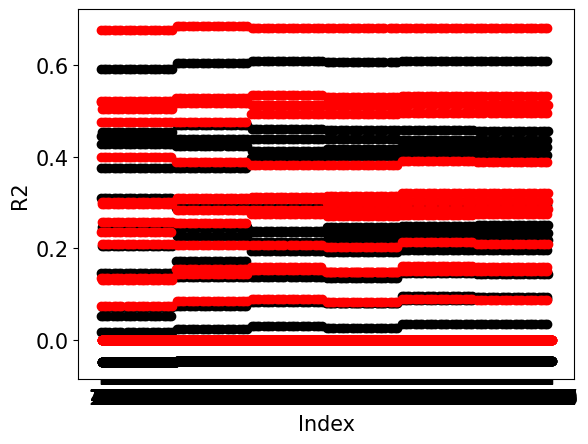

In [10]:
perc_split = 0.2
models.rf_model (0.2, moldescriptors_featues, Y)

train_mse:  27377.427814248134
test_mse:  49042.32098428636
r2_train:  0.15505409874149279
r2_test:  0.07480754308319748


/home/redo/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


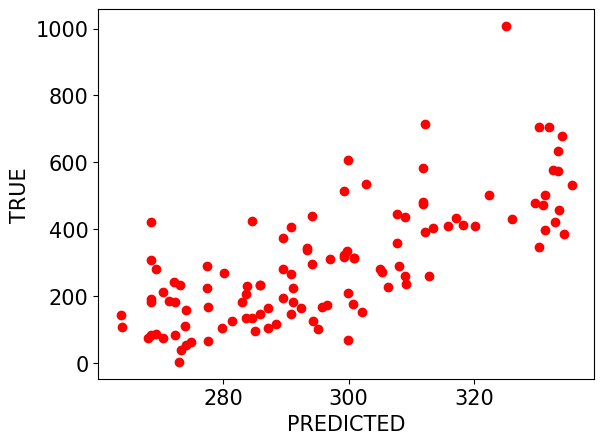

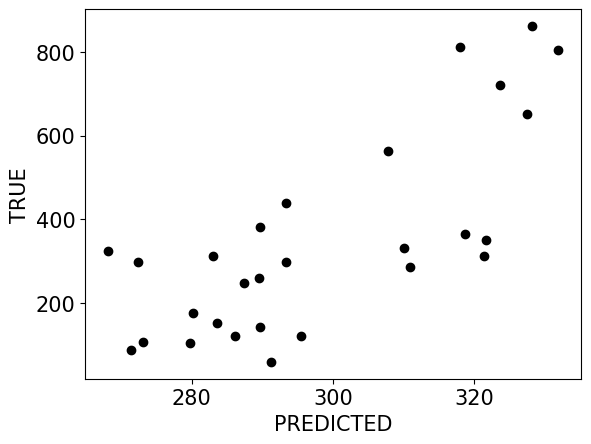

/home/redo/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


train_mse:  27254.60852598085
test_mse:  48477.57483839975
r2_train:  0.15884465404570292
r2_test:  0.08546158358863243


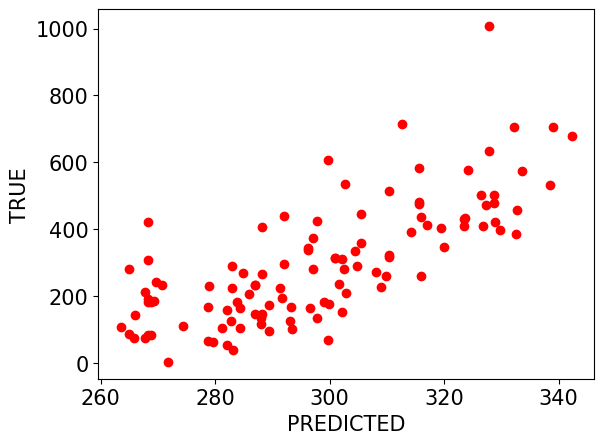

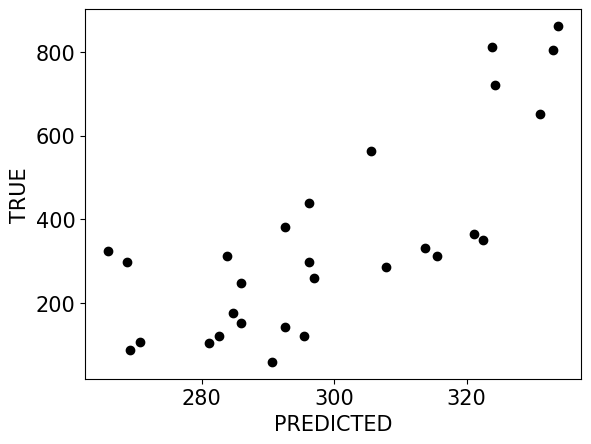

/home/redo/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


train_mse:  27377.427814248134
test_mse:  49042.32098428636
r2_train:  0.15505409874149279
r2_test:  0.07480754308319748


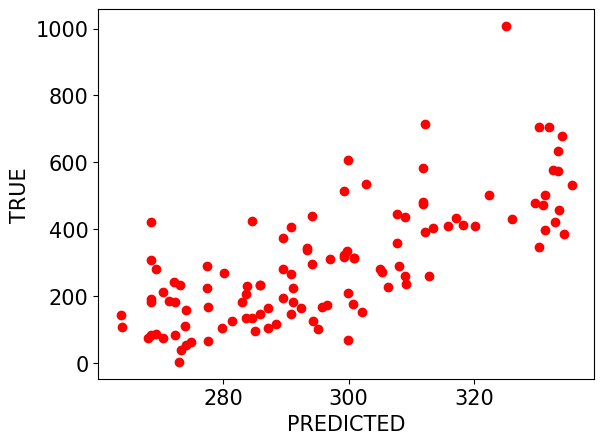

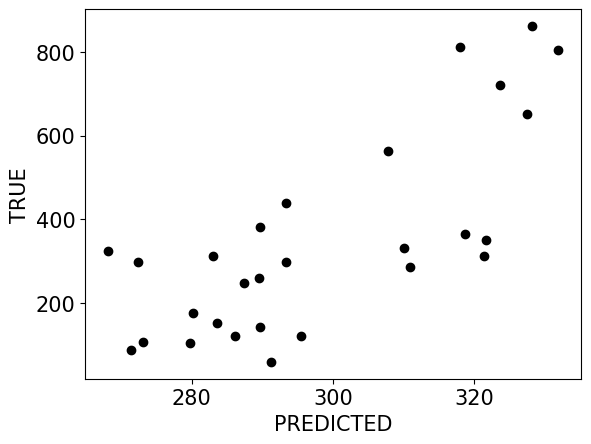

/home/redo/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


train_mse:  27254.60852598085
test_mse:  48477.57483839975
r2_train:  0.15884465404570292
r2_test:  0.08546158358863243


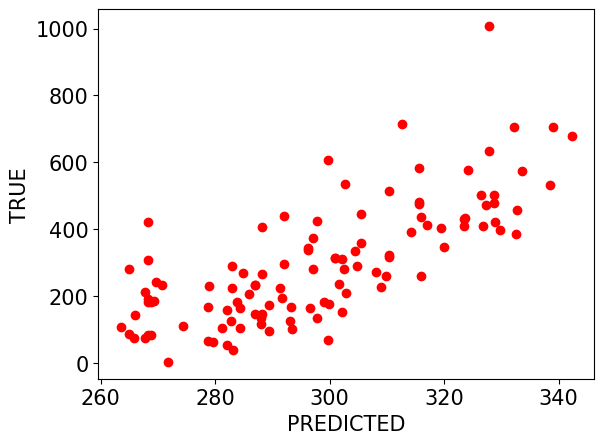

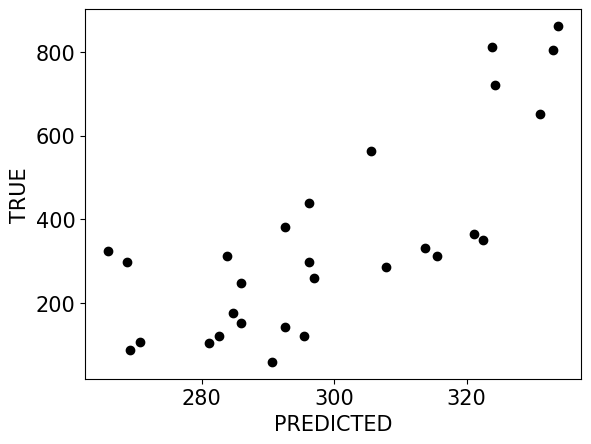

In [16]:
%reload_ext models
min_train_mse_hyper =  {'n_estimators': 100, 'max_depth': None, \
                        'min_samples_split': 2, 'min_samples_leaf': 10, \
                            'random_state': 42, 'bootstrap': True, \
                                'max_features': 100}
min_test_mse_hyper = {'n_estimators': 300, 'max_depth': None, \
                      'min_samples_split': 2, 'min_samples_leaf': 10, \
                        'random_state': 42, 'bootstrap': True, \
                            'max_features': 100}
max_train_r2_hyper = {'n_estimators': 100, 'max_depth': None, \
                      'min_samples_split': 2, 'min_samples_leaf': 10, \
                        'random_state': 42, 'bootstrap': True, \
                            'max_features': 100}
max_test_r2_hyper =  {'n_estimators': 300, 'max_depth': None, \
                      'min_samples_split': 2, 'min_samples_leaf': 10, \
                        'random_state': 42, 'bootstrap': True, \
                            'max_features': 100}

for d in [min_train_mse_hyper, min_test_mse_hyper, max_train_r2_hyper, max_test_r2_hyper]:
    perc_split = 0.2
    models.rf_model (0.2, moldescriptors_featues, Y, False, [d['n_estimators']], \
                     [d['max_depth']], [d['min_samples_split']], \
                         [d['min_samples_leaf']], [d['random_state']], \
                             [d['bootstrap']], [d['max_features']])


train_mse:  27254.60852598085
test_mse:  48477.57483839975
r2_train:  0.15884465404570292
r2_test:  0.08546158358863243


/home/redo/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


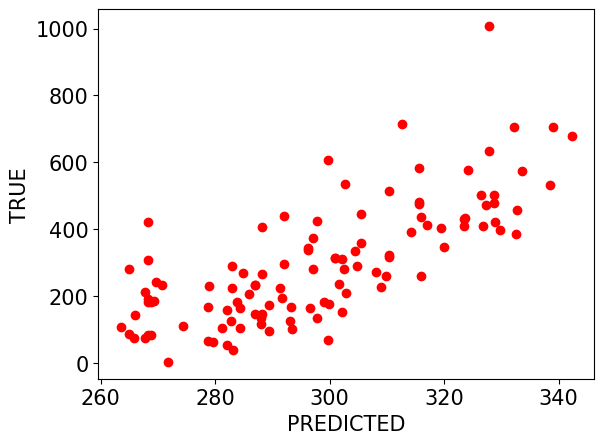

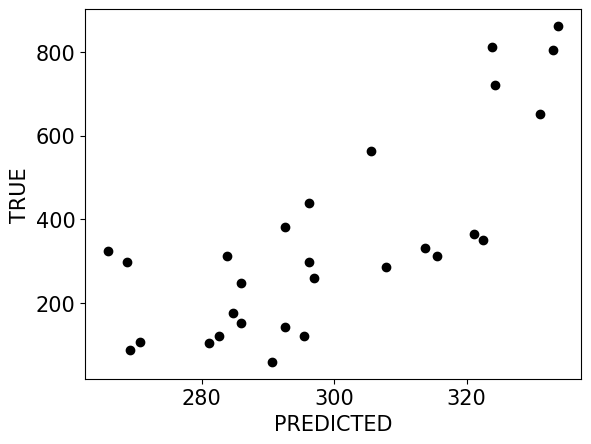

In [15]:
%reload_ext models

perc_split = 0.2
models.rf_model (0.2, moldescriptors_featues, Y, False, [300], [None], [2], [10], [42], [True], [100])

In [ ]:
#max_train_r2_hyper:  {'n_estimators': 100, 
'max_depth': None, 'min_samples_split': 2, 
'min_samples_leaf': 10, 'random_state': 42, 
'bootstrap': True, 'max_features': 100}
#max_test_r2_hyper:  {'n_estimators': 300,
#  'max_depth': None, 
# 'min_samples_split': 2,
#  'min_samples_leaf': 10, 
# 'ra
%reload_ext models

perc_split = 0.2
models.rf_model (0.2, moldescriptors_featues, Y, False, [100], [None], [2], [10], [42], [True], [100])

In [11]:
%reload_ext autoreload
%autoreload 2
import models 

modelshapes = [[64, 32, 16, 8, 4, 2], 
                [64, 32, 16, 8, 4], 
                [64, 32, 16, 8], 
                [64, 32, 16], 
                [64, 32], 
                [64]]


perc_split = 0.2
nepochs=10


models.nndmodel (0.2, np_counts_features, Y, nepochs, modelshapes)

AttributeError: module 'models' has no attribute 'nndmodel'